In [4]:
!pip install lifelines


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=f811ec5ea1d56dea41d5ef74d41636cc7992aa1eed50865c480b72f9208daaea
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [5]:
!pip install xgboost



In [6]:

# Basic data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Survival Analysis
from lifelines import KaplanMeierFitter, CoxPHFitter

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model evaluation
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter


In [9]:
import pandas as pd
data = pd.read_csv("Breast Cancer METABRIC.csv")



In [10]:
print("Shape of dataset:", data.shape)
print("\nColumn Info:")
data.info()



Shape of dataset: (2509, 34)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Patient ID                      2509 non-null   object 
 1   Age at Diagnosis                2498 non-null   float64
 2   Type of Breast Surgery          1955 non-null   object 
 3   Cancer Type                     2509 non-null   object 
 4   Cancer Type Detailed            2509 non-null   object 
 5   Cellularity                     1917 non-null   object 
 6   Chemotherapy                    1980 non-null   object 
 7   Pam50 + Claudin-low subtype     1980 non-null   object 
 8   Cohort                          2498 non-null   float64
 9   ER status measured by IHC       2426 non-null   object 
 10  ER Status                       2469 non-null   object 
 11  Neoplasm Histologic Grade       2388 non-null   floa

In [11]:
# Data Cleaning

# Check missing values in each column
missing = data.isnull().sum().sort_values(ascending=False)
print("Missing Values per Column:\n")
print(missing.head(15))  # Show top 15 columns with missing values

# Check data types
print("\nData Types:\n")
print(data.dtypes.head(15))

# Drop columns that are identifiers or irrelevant for modeling
cols_to_drop = ['Patient ID', 'Oncotree Code', 'Cohort', 'Tumor Other Histologic Subtype']
data = data.drop(columns=[c for c in cols_to_drop if c in data.columns], errors='ignore')

print("\n✅ Irrelevant columns dropped.")
print(f"New shape: {data.shape}")


Missing Values per Column:

3-Gene classifier subtype       745
Tumor Stage                     721
Primary Tumor Laterality        639
Cellularity                     592
Type of Breast Surgery          554
Inferred Menopausal State       529
Integrative Cluster             529
Hormone Therapy                 529
Pam50 + Claudin-low subtype     529
Chemotherapy                    529
PR Status                       529
HER2 Status                     529
Radio Therapy                   529
Patient's Vital Status          529
HER2 status measured by SNP6    529
dtype: int64

Data Types:

Patient ID                         object
Age at Diagnosis                  float64
Type of Breast Surgery             object
Cancer Type                        object
Cancer Type Detailed               object
Cellularity                        object
Chemotherapy                       object
Pam50 + Claudin-low subtype        object
Cohort                            float64
ER status measured by IHC  

In [12]:
print("Column names in the dataset:\n")
for col in data.columns:
    print(col)

Column names in the dataset:

Age at Diagnosis
Type of Breast Surgery
Cancer Type
Cancer Type Detailed
Cellularity
Chemotherapy
Pam50 + Claudin-low subtype
ER status measured by IHC
ER Status
Neoplasm Histologic Grade
HER2 status measured by SNP6
HER2 Status
Hormone Therapy
Inferred Menopausal State
Integrative Cluster
Primary Tumor Laterality
Lymph nodes examined positive
Mutation Count
Nottingham prognostic index
Overall Survival (Months)
Overall Survival Status
PR Status
Radio Therapy
Relapse Free Status (Months)
Relapse Free Status
Sex
3-Gene classifier subtype
Tumor Size
Tumor Stage
Patient's Vital Status


In [13]:
data = data.loc[:, ~data.columns.duplicated()]

[s for s in data.columns if "survival" in s.lower() or "vital" in s.lower()]


['Overall Survival (Months)',
 'Overall Survival Status',
 "Patient's Vital Status"]

In [14]:
# Check all columns that contain "survival"
[s for s in data.columns if "survival" in s.lower() or "vital" in s.lower()]


['Overall Survival (Months)',
 'Overall Survival Status',
 "Patient's Vital Status"]

In [15]:
# Step 2.2 (Fixed) — Clean survival columns safely

# Adjust these names based on your output above 👇
time_col = "Overall Survival (Months)"
status_col = "Overall Survival Status"

# Copy and clean
data["survival_months"] = pd.to_numeric(
    data[time_col].astype(str).str.replace(",", ""), errors="coerce"
)

data["survival_status"] = (
    data[status_col]
    .astype(str)
    .str.lower()
    .str.strip()
    .replace({
        "living": 0,
        "alive": 0,
        "deceased": 1,
        "died of disease": 1,
        "died of other causes": 1,
        "died": 1
    })
)

# Convert to numeric and drop missing
data["survival_status"] = pd.to_numeric(data["survival_status"], errors="coerce")
data = data.dropna(subset=["survival_months", "survival_status"])

print("✅ Cleaned survival columns successfully!")
print(data["survival_status"].value_counts())


✅ Cleaned survival columns successfully!
survival_status
1.0    1144
0.0     837
Name: count, dtype: int64


In [16]:
# Basic structure
print("Shape of dataset:", data.shape)
print("\nColumn types:\n", data.dtypes)
print("\nMissing values per column:\n", data.isnull().sum())


Shape of dataset: (1981, 32)

Column types:
 Age at Diagnosis                 float64
Type of Breast Surgery            object
Cancer Type                       object
Cancer Type Detailed              object
Cellularity                       object
Chemotherapy                      object
Pam50 + Claudin-low subtype       object
ER status measured by IHC         object
ER Status                         object
Neoplasm Histologic Grade        float64
HER2 status measured by SNP6      object
HER2 Status                       object
Hormone Therapy                   object
Inferred Menopausal State         object
Integrative Cluster               object
Primary Tumor Laterality          object
Lymph nodes examined positive    float64
Mutation Count                   float64
Nottingham prognostic index      float64
Overall Survival (Months)        float64
Overall Survival Status           object
PR Status                         object
Radio Therapy                     object
Relapse Free

# Survival Status Distribution

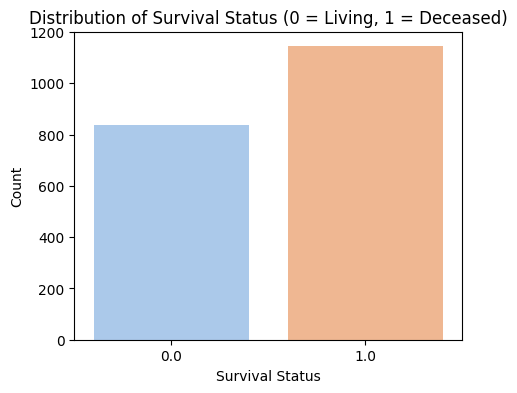

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.countplot(x="survival_status", data=data, palette="pastel")
plt.title("Distribution of Survival Status (0 = Living, 1 = Deceased)")
plt.xlabel("Survival Status")
plt.ylabel("Count")
plt.show()


In [18]:
print([col for col in data.columns])


['Age at Diagnosis', 'Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed', 'Cellularity', 'Chemotherapy', 'Pam50 + Claudin-low subtype', 'ER status measured by IHC', 'ER Status', 'Neoplasm Histologic Grade', 'HER2 status measured by SNP6', 'HER2 Status', 'Hormone Therapy', 'Inferred Menopausal State', 'Integrative Cluster', 'Primary Tumor Laterality', 'Lymph nodes examined positive', 'Mutation Count', 'Nottingham prognostic index', 'Overall Survival (Months)', 'Overall Survival Status', 'PR Status', 'Radio Therapy', 'Relapse Free Status (Months)', 'Relapse Free Status', 'Sex', '3-Gene classifier subtype', 'Tumor Size', 'Tumor Stage', "Patient's Vital Status", 'survival_months', 'survival_status']


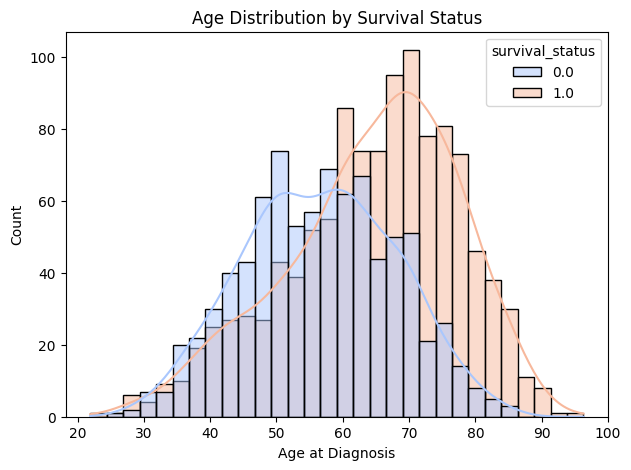

In [19]:
plt.figure(figsize=(7,5))
sns.histplot(data=data, x="Age at Diagnosis", hue="survival_status", kde=True, bins=30, palette="coolwarm")
plt.title("Age Distribution by Survival Status")
plt.xlabel("Age at Diagnosis")
plt.ylabel("Count")
plt.show()


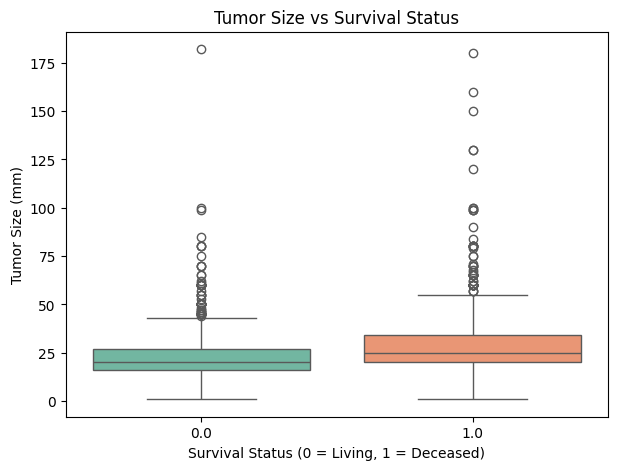

In [20]:
plt.figure(figsize=(7,5))
sns.boxplot(x="survival_status", y="Tumor Size", data=data, palette="Set2")
plt.title("Tumor Size vs Survival Status")
plt.xlabel("Survival Status (0 = Living, 1 = Deceased)")
plt.ylabel("Tumor Size (mm)")
plt.show()


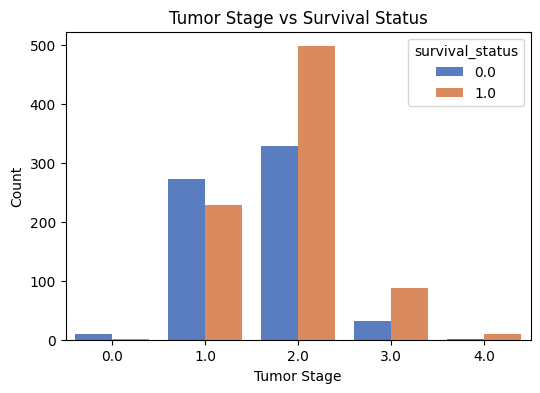

In [21]:
plt.figure(figsize=(6,4))
sns.countplot(x="Tumor Stage", hue="survival_status", data=data, palette="muted")
plt.title("Tumor Stage vs Survival Status")
plt.xlabel("Tumor Stage")
plt.ylabel("Count")
plt.show()


# Kaplan-Meier Survival Analysis

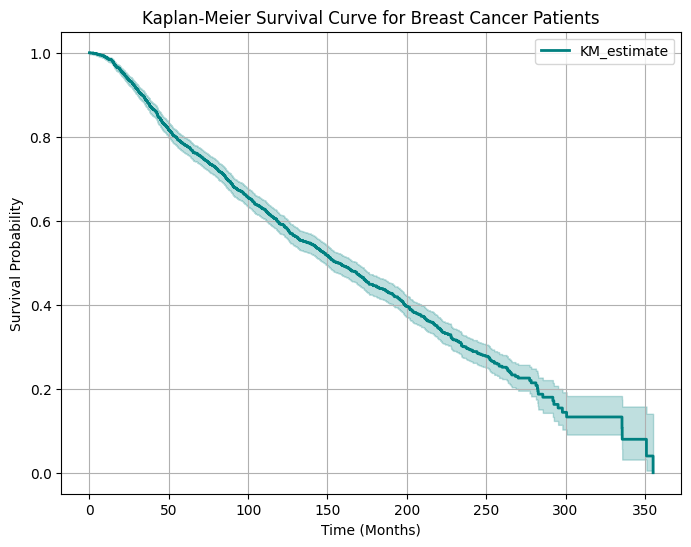

In [22]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Fit the model on the data
kmf.fit(durations=data["survival_months"], event_observed=data["survival_status"])

# Plot the survival function
plt.figure(figsize=(8,6))
kmf.plot(ci_show=True, color="teal", linewidth=2)
plt.title("Kaplan-Meier Survival Curve for Breast Cancer Patients")
plt.xlabel("Time (Months)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()


# Feature Engineering

In [23]:
# Select only relevant columns for modeling
selected_cols = [
    "Age at Diagnosis", "Tumor Size", "Tumor Stage",
    "Lymph nodes examined positive", "Cellularity",
    "Chemotherapy", "Hormone Therapy", "Radio Therapy",
    "ER Status", "PR Status", "HER2 Status",
    "survival_months", "survival_status"
]

df_model = data[selected_cols].copy()

print("Shape after selecting relevant features:", df_model.shape)
df_model.head()


Shape after selecting relevant features: (1981, 13)


,Age at Diagnosis,Tumor Size,Tumor Stage,Lymph nodes examined positive,Cellularity,Chemotherapy,Hormone Therapy,Radio Therapy,ER Status,PR Status,HER2 Status,survival_months,survival_status
0,75.65,22.0,2.0,10.0,NaN,No,Yes,Yes,Positive,Negative,Negative,140.500000,0.0
1,43.19,10.0,1.0,0.0,High,No,Yes,Yes,Positive,Positive,Negative,84.633333,0.0
2,48.87,15.0,2.0,1.0,High,Yes,Yes,No,Positive,Positive,Negative,163.700000,1.0
3,47.68,25.0,2.0,3.0,Moderate,Yes,Yes,Yes,Positive,Positive,Negative,164.933333,0.0
4,76.97,40.0,2.0,8.0,High,Yes,Yes,Yes,Positive,Positive,Negative,41.366667,1.0


In [24]:
# Check for missing values
df_model.isnull().sum()


,0
Age at Diagnosis,0
Tumor Size,26
Tumor Stage,515
Lymph nodes examined positive,76
Cellularity,64
Chemotherapy,1
Hormone Therapy,1
Radio Therapy,1
ER Status,0
PR Status,1


In [25]:
# Fill categorical missing values with mode
categorical_cols = df_model.select_dtypes(include="object").columns
for col in categorical_cols:
    df_model[col].fillna(df_model[col].mode()[0], inplace=True)

# Fill numeric missing values with median
numeric_cols = df_model.select_dtypes(include=["int64", "float64"]).columns
for col in numeric_cols:
    df_model[col].fillna(df_model[col].median(), inplace=True)

# Confirm again
df_model.isnull().sum()


,0
Age at Diagnosis,0
Tumor Size,0
Tumor Stage,0
Lymph nodes examined positive,0
Cellularity,0
Chemotherapy,0
Hormone Therapy,0
Radio Therapy,0
ER Status,0
PR Status,0


we’ll convert categorical features like ER Status, PR Status, Cellularity, etc. to numeric.

In [26]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

for col in categorical_cols:
    df_model[col] = encoder.fit_transform(df_model[col])

df_model.head()


,Age at Diagnosis,Tumor Size,Tumor Stage,Lymph nodes examined positive,Cellularity,Chemotherapy,Hormone Therapy,Radio Therapy,ER Status,PR Status,HER2 Status,survival_months,survival_status
0,75.65,22.0,2.0,10.0,0,0,1,1,1,0,0,140.500000,0.0
1,43.19,10.0,1.0,0.0,0,0,1,1,1,1,0,84.633333,0.0
2,48.87,15.0,2.0,1.0,0,1,1,0,1,1,0,163.700000,1.0
3,47.68,25.0,2.0,3.0,2,1,1,1,1,1,0,164.933333,0.0
4,76.97,40.0,2.0,8.0,0,1,1,1,1,1,0,41.366667,1.0


# KNN Model


In [28]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [29]:
#  Prepare X and y
X = df_model.drop(columns=['survival_status', 'survival_months'], errors='ignore')
y = df_model['survival_status']

In [30]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [31]:
# Build a pipeline: scaler + KNN
pipe = Pipeline([
    ('scaler', StandardScaler()),      # scales all numeric features
    ('knn', KNeighborsClassifier())
])


In [32]:
#Grid search for best k (number of neighbors)
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]   # p=1 -> Manhattan, p=2 -> Euclidean
}
cv = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
cv.fit(X_train, y_train)

print("Best params:", cv.best_params_)
print("Best CV ROC-AUC:", cv.best_score_)


Best params: {'knn__n_neighbors': 11, 'knn__p': 1, 'knn__weights': 'uniform'}
Best CV ROC-AUC: 0.6611820718912524


In [33]:
# Evaluate on test set
best_model = cv.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
rocauc = roc_auc_score(y_test, y_proba)
print("\nTest Accuracy: {:.4f}".format(acc))
print("Test ROC-AUC: {:.4f}".format(rocauc))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.6650
Test ROC-AUC: 0.7153

Classification Report:
               precision    recall  f1-score   support

         0.0       0.61      0.57      0.59       168
         1.0       0.70      0.74      0.72       229

    accuracy                           0.66       397
   macro avg       0.66      0.65      0.65       397
weighted avg       0.66      0.66      0.66       397



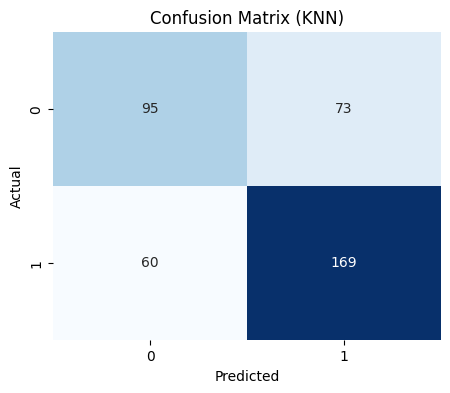

In [34]:
# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (KNN)")
plt.show()

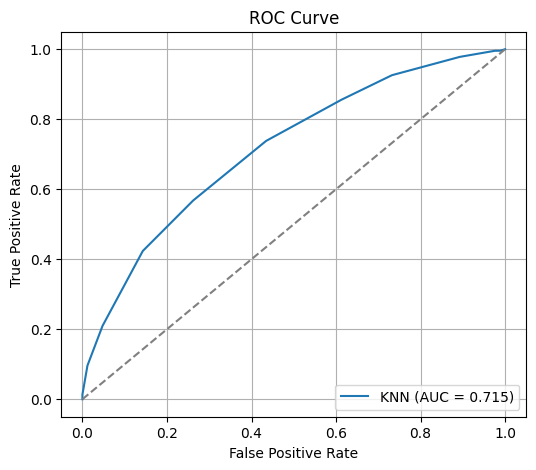

In [35]:


#ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"KNN (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Logistic regression Model

In [36]:
# Step 5 – Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve

# pipeline: scaling + logistic regression
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=500, random_state=42))
])

# hyperparameter grid
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100],     # regularization strength
    'logreg__penalty': ['l2'],                # use L2 regularization
    'logreg__solver': ['lbfgs', 'liblinear']  # optimization algorithms
}

# grid search with 5-fold cross-validation
grid_logreg = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# fit on training data
grid_logreg.fit(X_train, y_train)

# best parameters and cross-val score
print("Best params:", grid_logreg.best_params_)
print("Best CV ROC-AUC:", grid_logreg.best_score_)

# evaluate on test data
y_pred_lr  = grid_logreg.predict(X_test)
y_prob_lr  = grid_logreg.predict_proba(X_test)[:,1]

acc_lr  = accuracy_score(y_test, y_pred_lr)
roc_lr  = roc_auc_score(y_test, y_prob_lr)

print("\nTest Accuracy:", round(acc_lr, 4))
print("Test ROC-AUC:", round(roc_lr, 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'logreg__C': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best CV ROC-AUC: 0.725135998793166

Test Accuracy: 0.6574
Test ROC-AUC: 0.7251

Classification Report:
               precision    recall  f1-score   support

         0.0       0.61      0.54      0.57       168
         1.0       0.69      0.75      0.72       229

    accuracy                           0.66       397
   macro avg       0.65      0.64      0.64       397
weighted avg       0.65      0.66      0.65       397



# Decision Tree

In [37]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


# Ensure reproducibility
RND = 42

results = []  # to collect summary for comparison (model, accuracy, roc_auc)


dt_pipe = Pipeline([
    ('scaler', StandardScaler()),   # scaling won't hurt; trees don't require it
    ('dt', DecisionTreeClassifier(random_state=RND))
])

dt_param_grid = {
    'dt__max_depth': [3, 5, 7, 9, None],
    'dt__min_samples_leaf': [1, 5, 10, 20],
    'dt__criterion': ['gini', 'entropy']
}

dt_cv = GridSearchCV(dt_pipe, dt_param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=0)
dt_cv.fit(X_train, y_train)

dt_best = dt_cv.best_estimator_
y_pred_dt = dt_best.predict(X_test)
y_proba_dt = dt_best.predict_proba(X_test)[:, 1]

acc_dt = accuracy_score(y_test, y_pred_dt)
roc_dt = roc_auc_score(y_test, y_proba_dt)

print("Decision Tree - Best params:", dt_cv.best_params_)
print("Decision Tree - CV ROC-AUC:", round(dt_cv.best_score_, 4))
print("Decision Tree - Test Accuracy:", round(acc_dt, 4))
print("Decision Tree - Test ROC-AUC:", round(roc_dt, 4))
print("\nDecision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))

results.append(('Decision Tree', acc_dt, roc_dt, dt_cv.best_score_))

Decision Tree - Best params: {'dt__criterion': 'entropy', 'dt__max_depth': 3, 'dt__min_samples_leaf': 20}
Decision Tree - CV ROC-AUC: 0.6938
Decision Tree - Test Accuracy: 0.6448
Decision Tree - Test ROC-AUC: 0.6919

Decision Tree Classification Report:
               precision    recall  f1-score   support

         0.0       0.60      0.48      0.53       168
         1.0       0.67      0.77      0.71       229

    accuracy                           0.64       397
   macro avg       0.63      0.62      0.62       397
weighted avg       0.64      0.64      0.64       397



# Support Vector Machine (SVM)


In [38]:
# We use probability=True to get predict_proba for ROC; this makes training slower.
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),   # SVM requires scaling
    ('svm', SVC(probability=True, random_state=RND))
])

svm_param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['rbf', 'linear'],
    'svm__gamma': ['scale', 'auto']   # gamma only used for rbf
}

svm_cv = GridSearchCV(svm_pipe, svm_param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=0)
svm_cv.fit(X_train, y_train)

svm_best = svm_cv.best_estimator_
y_pred_svm = svm_best.predict(X_test)
y_proba_svm = svm_best.predict_proba(X_test)[:, 1]

acc_svm = accuracy_score(y_test, y_pred_svm)
roc_svm = roc_auc_score(y_test, y_proba_svm)

print("\nSVM - Best params:", svm_cv.best_params_)
print("SVM - CV ROC-AUC:", round(svm_cv.best_score_, 4))
print("SVM - Test Accuracy:", round(acc_svm, 4))
print("SVM - Test ROC-AUC:", round(roc_svm, 4))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm))

results.append(('SVM', acc_svm, roc_svm, svm_cv.best_score_))


SVM - Best params: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
SVM - CV ROC-AUC: 0.7234
SVM - Test Accuracy: 0.6599
SVM - Test ROC-AUC: 0.7241

SVM Classification Report:
               precision    recall  f1-score   support

         0.0       0.60      0.57      0.59       168
         1.0       0.70      0.72      0.71       229

    accuracy                           0.66       397
   macro avg       0.65      0.65      0.65       397
weighted avg       0.66      0.66      0.66       397



KNN best params: {'knn__n_neighbors': 11, 'knn__p': 1, 'knn__weights': 'uniform'} CV AUC: 0.6612
LogReg best params: {'lr__C': 100, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'} CV AUC: 0.7251
Decision Tree best params: {'dt__criterion': 'entropy', 'dt__max_depth': 3, 'dt__min_samples_leaf': 20} CV AUC: 0.6938
SVM best params: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'} CV AUC: 0.7234

--- Model comparison ---
                 Model  Test Accuracy  Test ROC-AUC  CV ROC-AUC
0  Logistic Regression         0.6574        0.7251      0.7251
1                  SVM         0.6599        0.7241      0.7234
2                  KNN         0.6650        0.7153      0.6612
3        Decision Tree         0.6448        0.6919      0.6938


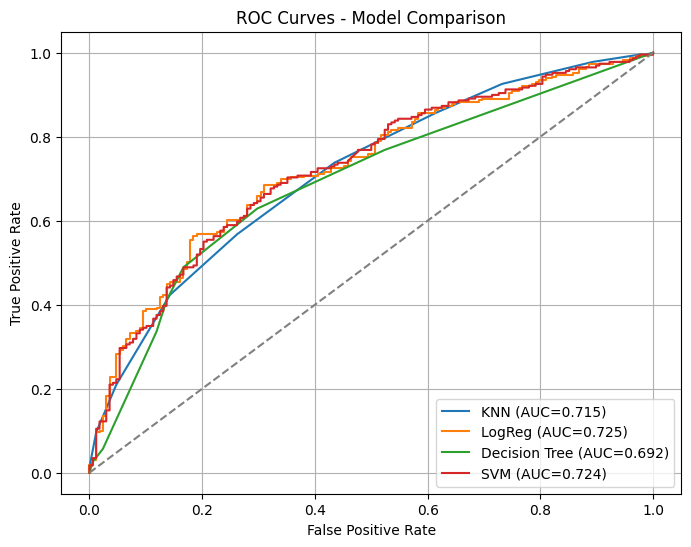


--- Detailed Classification Reports ---

Model: KNN
              precision    recall  f1-score   support

         0.0       0.61      0.57      0.59       168
         1.0       0.70      0.74      0.72       229

    accuracy                           0.66       397
   macro avg       0.66      0.65      0.65       397
weighted avg       0.66      0.66      0.66       397

------------------------------------------------------------
Model: LogReg
              precision    recall  f1-score   support

         0.0       0.61      0.54      0.57       168
         1.0       0.69      0.75      0.72       229

    accuracy                           0.66       397
   macro avg       0.65      0.64      0.64       397
weighted avg       0.65      0.66      0.65       397

------------------------------------------------------------
Model: Decision Tree
              precision    recall  f1-score   support

         0.0       0.60      0.48      0.53       168
         1.0       0.67    

In [40]:
# Single cell: Train & compare KNN, Logistic Regression, Decision Tree, and SVM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

RND = 42
cv = 5
results = []

# ---------------------------
# 1) KNN
# ---------------------------
pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
param_knn = {
    'knn__n_neighbors': [3,5,7,9,11],
    'knn__weights': ['uniform','distance'],
    'knn__p': [1,2]
}
gs_knn = GridSearchCV(pipe_knn, param_knn, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=0)
gs_knn.fit(X_train, y_train)
best_knn = gs_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)
y_proba_knn = best_knn.predict_proba(X_test)[:,1]
acc_knn = accuracy_score(y_test, y_pred_knn)
roc_knn = roc_auc_score(y_test, y_proba_knn)
print("KNN best params:", gs_knn.best_params_, "CV AUC:", round(gs_knn.best_score_,4))

results.append({
    'Model':'KNN', 'Estimator':best_knn, 'Test Accuracy':acc_knn, 'Test ROC-AUC':roc_knn, 'CV ROC-AUC':gs_knn.best_score_
})

# ---------------------------
# 2) Logistic Regression
# ---------------------------
pipe_lr = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(max_iter=1000, random_state=RND))])
param_lr = {
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__penalty': ['l2'],
    'lr__solver': ['lbfgs','liblinear']
}
gs_lr = GridSearchCV(pipe_lr, param_lr, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=0)
gs_lr.fit(X_train, y_train)
best_lr = gs_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)
y_proba_lr = best_lr.predict_proba(X_test)[:,1]
acc_lr = accuracy_score(y_test, y_pred_lr)
roc_lr = roc_auc_score(y_test, y_proba_lr)
print("LogReg best params:", gs_lr.best_params_, "CV AUC:", round(gs_lr.best_score_,4))

results.append({
    'Model':'Logistic Regression', 'Estimator':best_lr, 'Test Accuracy':acc_lr, 'Test ROC-AUC':roc_lr, 'CV ROC-AUC':gs_lr.best_score_
})

# ---------------------------
# 3) Decision Tree
# ---------------------------
pipe_dt = Pipeline([('scaler', StandardScaler()), ('dt', DecisionTreeClassifier(random_state=RND))])
param_dt = {
    'dt__max_depth': [3,5,7,9, None],
    'dt__min_samples_leaf': [1,5,10,20],
    'dt__criterion': ['gini','entropy']
}
gs_dt = GridSearchCV(pipe_dt, param_dt, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=0)
gs_dt.fit(X_train, y_train)
best_dt = gs_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)
y_proba_dt = best_dt.predict_proba(X_test)[:,1]
acc_dt = accuracy_score(y_test, y_pred_dt)
roc_dt = roc_auc_score(y_test, y_proba_dt)
print("Decision Tree best params:", gs_dt.best_params_, "CV AUC:", round(gs_dt.best_score_,4))

results.append({
    'Model':'Decision Tree', 'Estimator':best_dt, 'Test Accuracy':acc_dt, 'Test ROC-AUC':roc_dt, 'CV ROC-AUC':gs_dt.best_score_
})

# ---------------------------
# 4) SVM
# ---------------------------
pipe_svm = Pipeline([('scaler', StandardScaler()), ('svm', SVC(probability=True, random_state=RND))])
param_svm = {
    'svm__C': [0.1,1,10],
    'svm__kernel': ['rbf','linear'],
    'svm__gamma': ['scale','auto']
}
gs_svm = GridSearchCV(pipe_svm, param_svm, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=0)
gs_svm.fit(X_train, y_train)
best_svm = gs_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)
y_proba_svm = best_svm.predict_proba(X_test)[:,1]
acc_svm = accuracy_score(y_test, y_pred_svm)
roc_svm = roc_auc_score(y_test, y_proba_svm)
print("SVM best params:", gs_svm.best_params_, "CV AUC:", round(gs_svm.best_score_,4))

results.append({
    'Model':'SVM', 'Estimator':best_svm, 'Test Accuracy':acc_svm, 'Test ROC-AUC':roc_svm, 'CV ROC-AUC':gs_svm.best_score_
})

# ---------------------------
# Summary table and ROC plot
# ---------------------------
summary = pd.DataFrame([{
    'Model': r['Model'],
    'Test Accuracy': round(r['Test Accuracy'],4),
    'Test ROC-AUC': round(r['Test ROC-AUC'],4),
    'CV ROC-AUC': round(r['CV ROC-AUC'],4)
} for r in results]).sort_values(by='Test ROC-AUC', ascending=False).reset_index(drop=True)

print("\n--- Model comparison ---")
print(summary)

# Plot ROC curves together
plt.figure(figsize=(8,6))
fpr, tpr, _ = roc_curve(y_test, y_proba_knn); plt.plot(fpr, tpr, label=f"KNN (AUC={roc_knn:.3f})")
fpr, tpr, _ = roc_curve(y_test, y_proba_lr);  plt.plot(fpr, tpr, label=f"LogReg (AUC={roc_lr:.3f})")
fpr, tpr, _ = roc_curve(y_test, y_proba_dt);  plt.plot(fpr, tpr, label=f"Decision Tree (AUC={roc_dt:.3f})")
fpr, tpr, _ = roc_curve(y_test, y_proba_svm); plt.plot(fpr, tpr, label=f"SVM (AUC={roc_svm:.3f})")

plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Model Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ---------------------------
# Print detailed classification reports (optional)
# ---------------------------
print("\n--- Detailed Classification Reports ---\n")
for name, y_pred in [('KNN', y_pred_knn), ('LogReg', y_pred_lr), ('Decision Tree', y_pred_dt), ('SVM', y_pred_svm)]:
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print("-"*60)
